#### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import seaborn as sns
import efficientnet.keras as efn
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Average, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
import cv2
import json
from tensorflow.keras.utils import Sequence
import os
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageDraw
from tensorflow.keras import layers, models
from shapely.geometry import box as shapely_box
from shapely.ops import unary_union
from ultralytics import YOLO

## Tile Classification

#### VGG19

##### 1. Data preprocessing

In [ ]:
#defining the train, validation and test dataset path
train_path = 'G:\\My Drive\\TileDataset\\train'
valid_path = 'G:\\My Drive\\TileDataset\\val'
test_path = 'G:\\My Drive\\TileDataset\\test'

#defining the image size
image_size = [224, 224]

#performing image augmentation
train_datagen = ImageDataGenerator( rescale=1./255,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1.255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size=5,
                                                 class_mode='categorical')
validation_set = validation_datagen.flow_from_directory(valid_path,
                                                        target_size = (224,224),
                                                        batch_size=5,
                                                        class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224,224),
                                            batch_size=5,
                                            class_mode='categorical',
                                            shuffle=False
                                            )

Found 184 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


##### defining the vgg19 base model

In [ ]:
model = VGG19(input_shape = image_size+[3], weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
vgg19 = Flatten()(model.output)
vgg19 = Dense(1024, activation='relu')(vgg19)
output = Dense(2, activation='softmax')(vgg19)

#creating model object
vgg19_model = Model(inputs=model.input, outputs=output)
#compiling the model
vgg19_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
#model architecture summary
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# building the model
history = vgg19_model.fit(training_set,
                          validation_data = validation_set,
                          epochs = 20
                          )

Epoch 1/20
37/37 [==============================] - 60s 2s/step - loss: 1.2744 - accuracy: 0.5489 - val_loss: 0.6891 - val_accuracy: 0.5455
Epoch 2/20
37/37 [==============================] - 57s 2s/step - loss: 0.6874 - accuracy: 0.5435 - val_loss: 0.6598 - val_accuracy: 0.5152
Epoch 3/20
37/37 [==============================] - 59s 2s/step - loss: 0.6494 - accuracy: 0.5707 - val_loss: 0.7549 - val_accuracy: 0.4848
Epoch 4/20
37/37 [==============================] - 56s 2s/step - loss: 0.6456 - accuracy: 0.6359 - val_loss: 0.6815 - val_accuracy: 0.5455
Epoch 5/20
37/37 [==============================] - 56s 2s/step - loss: 0.6789 - accuracy: 0.6033 - val_loss: 0.6286 - val_accuracy: 0.6364
Epoch 6/20
37/37 [==============================] - 57s 2s/step - loss: 0.5925 - accuracy: 0.6739 - val_loss: 0.5979 - val_accuracy: 0.7273
Epoch 7/20
37/37 [==============================] - 59s 2s/step - loss: 0.6442 - accuracy: 0.6902 - val_loss: 0.5643 - val_accuracy: 0.7879
Epoch 8/20
37/37 [==

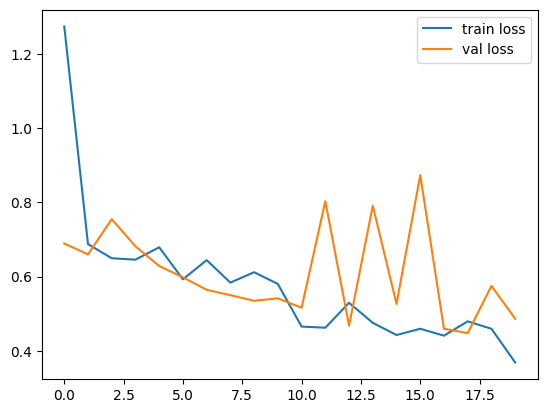

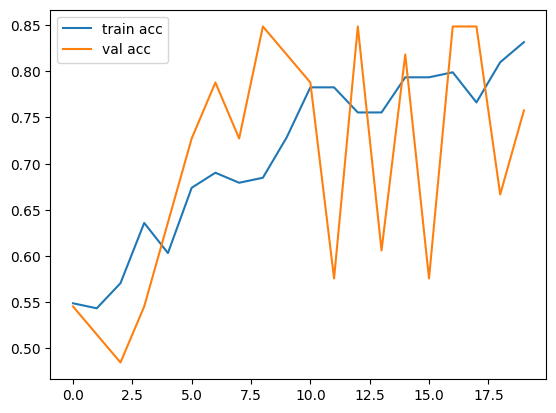

In [ ]:
#plotting the accuracy and loss graph
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
#making predictions on the test set
predictions = vgg19_model.predict(test_set, verbose=1)

8/8 [==============================] - 9s 1s/step


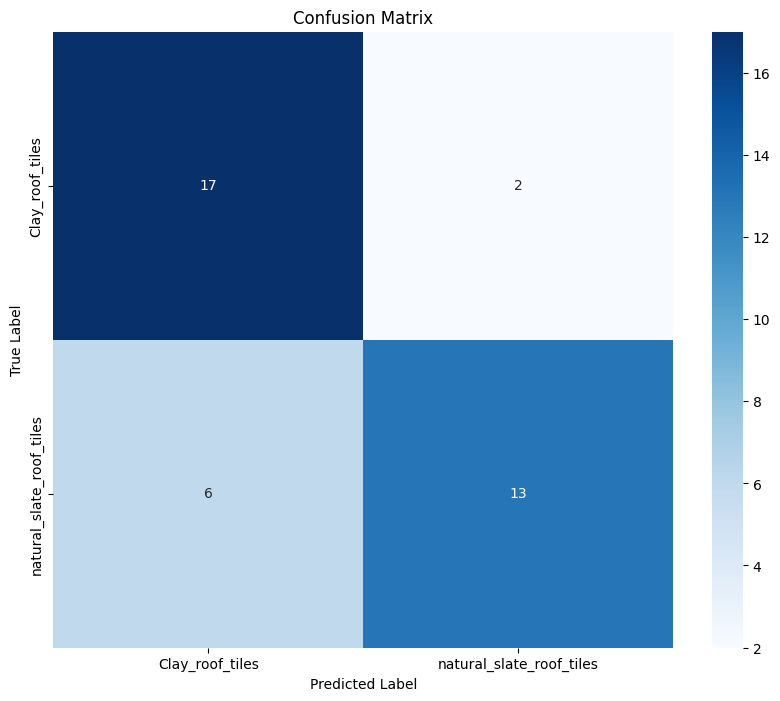

                          precision    recall  f1-score   support

         Clay_roof_tiles       0.74      0.89      0.81        19
natural_slate_roof_tiles       0.87      0.68      0.76        19

                accuracy                           0.79        38
               macro avg       0.80      0.79      0.79        38
            weighted avg       0.80      0.79      0.79        38



In [ ]:
#evaluating the model performance
#getting the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

#getting the true class indices
true_class_indices = test_set.classes
class_labels = list(test_set.class_indices.keys())

# Generating the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Generating and printing the classification report
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_labels)
print(report)

In [ ]:
vgg19_model.save('TileClassificationvgg19_79.h5')

#### InceptionV3

##### data preparation

In [ ]:
#defining the train, validation and test dataset path
train_path = 'G:\\My Drive\\TileDataset\\train'
valid_path = 'G:\\My Drive\\TileDataset\\val'
test_path = 'G:\\My Drive\\TileDataset\\test'

#defining the image size
#image_size = [224, 224]

#performing image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1.255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (150,150),
                                                 batch_size=4,
                                                 class_mode='categorical')
validation_set = validation_datagen.flow_from_directory(valid_path,
                                                        target_size = (150,150),
                                                        batch_size=4,
                                                        class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (150,150),
                                            batch_size=4,
                                            class_mode='categorical',
                                            shuffle=False)

Found 184 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


##### defining the base model

In [ ]:
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
inception_model = Flatten()(base_model.output)
inception_model = Dense(1024, activation='relu')(inception_model)
output = Dense(2, activation='softmax')(inception_model)
model = Model(base_model.input,output)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# building the model
history = model.fit(training_set,
                          validation_data = validation_set,
                          epochs = 20
                          )

Epoch 1/20
46/46 [==============================] - 35s 558ms/step - loss: 7.7960 - acc: 0.7880 - val_loss: 2.4849 - val_acc: 0.9091
Epoch 2/20
46/46 [==============================] - 20s 424ms/step - loss: 1.9829 - acc: 0.9402 - val_loss: 5.7799 - val_acc: 0.8182
Epoch 3/20
46/46 [==============================] - 20s 436ms/step - loss: 3.2335 - acc: 0.8641 - val_loss: 1.2555 - val_acc: 0.8485
Epoch 4/20
46/46 [==============================] - 19s 415ms/step - loss: 1.3464 - acc: 0.9348 - val_loss: 2.9744 - val_acc: 0.8485
Epoch 5/20
46/46 [==============================] - 19s 408ms/step - loss: 0.2186 - acc: 0.9783 - val_loss: 3.2130 - val_acc: 0.8788
Epoch 6/20
46/46 [==============================] - 18s 398ms/step - loss: 0.8716 - acc: 0.9457 - val_loss: 0.9592 - val_acc: 0.8485
Epoch 7/20
46/46 [==============================] - 19s 420ms/step - loss: 0.6264 - acc: 0.9457 - val_loss: 0.7469 - val_acc: 0.8788
Epoch 8/20
46/46 [==============================] - 19s 414ms/step - 

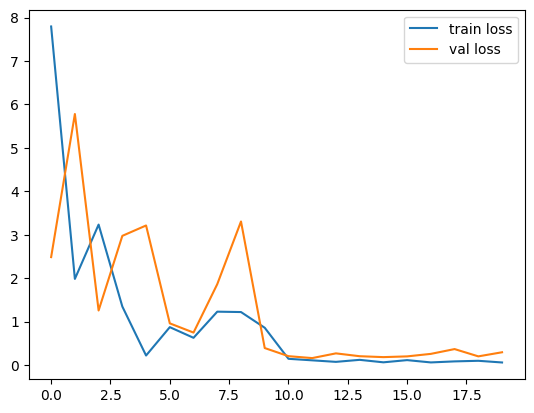

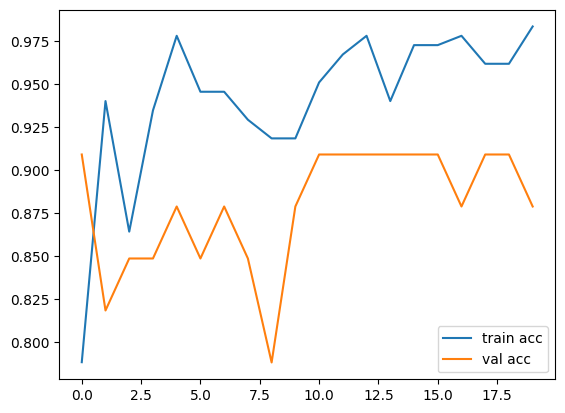

In [ ]:
#plotting the accuracy and loss graph
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
#making predictions on the test set
predictions = model.predict(test_set, verbose=1)

10/10 [==============================] - 6s 302ms/step


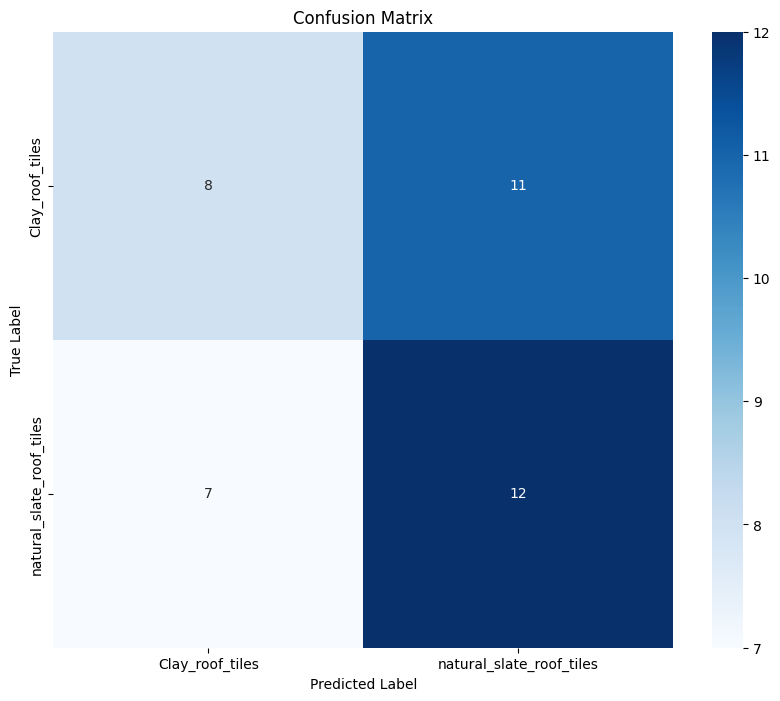

                          precision    recall  f1-score   support

         Clay_roof_tiles       0.53      0.42      0.47        19
natural_slate_roof_tiles       0.52      0.63      0.57        19

                accuracy                           0.53        38
               macro avg       0.53      0.53      0.52        38
            weighted avg       0.53      0.53      0.52        38



In [ ]:
#evaluating the model performance
#getting the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

#getting the true class indices
true_class_indices = test_set.classes
class_labels = list(test_set.class_indices.keys())

# Generating the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Generating and printing the classification report
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_labels)
print(report)

In [ ]:
model.save('TileClassificationInception.h5')

#### Ensemble Model

##### Data Preparation

In [ ]:
#defining the train, validation and test dataset path
train_path = 'G:\\My Drive\\TileDataset\\train'
valid_path = 'G:\\My Drive\\TileDataset\\val'
test_path = 'G:\\My Drive\\TileDataset\\test'

#defining the image size
#image_size = [224, 224]

#performing image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size=4,
                                                 class_mode='categorical')
validation_set = validation_datagen.flow_from_directory(valid_path,
                                                        target_size = (224,224),
                                                        batch_size=4,
                                                        class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224,224),
                                            batch_size=4,
                                            class_mode='categorical',
                                            shuffle=False)

Found 184 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


##### creating the models

In [ ]:

# Create base models
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
vgg_model = base_model_vgg.output
vgg_model = GlobalAveragePooling2D()(vgg_model)
vgg_model = Dense(1024, activation='relu')(vgg_model)
predictions_vgg = Dense(2, activation='softmax')(vgg_model)

# Add custom layers on top of ResNet50
resnet_model = base_model_resnet.output
resnet_model = GlobalAveragePooling2D()(resnet_model)
resnet_model = Dense(1024, activation='relu')(resnet_model)
predictions_resnet = Dense(2, activation='softmax')(resnet_model)

# Create the models
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)

# Compile the models
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


##### Training and compiling the ensemble models

In [ ]:
# Train the models
history_vgg = model_vgg.fit(
    training_set,
    validation_data=validation_set,
    epochs=15
)

history_resnet = model_resnet.fit(
    training_set,
    validation_data=validation_set,
    epochs=15
)


input_tensor = Input(shape=(224, 224, 3))
vgg_output = model_vgg(input_tensor)
resnet_output = model_resnet(input_tensor)
averaged_output = Average()([vgg_output, resnet_output])

ensemble_model = Model(inputs=input_tensor, outputs=averaged_output)
ensemble_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
46/46 [==============================] - 212s 5s/step - loss: 0.7365 - accuracy: 0.4946 - val_loss: 0.6979 - val_accuracy: 0.5152
Epoch 2/15
46/46 [==============================] - 212s 5s/step - loss: 0.6953 - accuracy: 0.4728 - val_loss: 0.6931 - val_accuracy: 0.4848
Epoch 3/15
46/46 [==============================] - 209s 5s/step - loss: 0.6870 - accuracy: 0.5815 - val_loss: 0.6924 - val_accuracy: 0.5152
Epoch 4/15
46/46 [==============================] - 218s 5s/step - loss: 0.6652 - accuracy: 0.6087 - val_loss: 0.6940 - val_accuracy: 0.4848
Epoch 5/15
46/46 [==============================] - 212s 5s/step - loss: 0.6962 - accuracy: 0.4837 - val_loss: 0.6937 - val_accuracy: 0.4848
Epoch 6/15
46/46 [==============================] - 208s 5s/step - loss: 0.6885 - accuracy: 0.5380 - val_loss: 0.6818 - val_accuracy: 0.5152
Epoch 7/15
46/46 [==============================] - 207s 5s/step - loss: 0.4326 - accuracy: 0.7228 - val_loss: 0.3231 - val_accuracy: 0.9697
Epoch 8/15
46

VGG


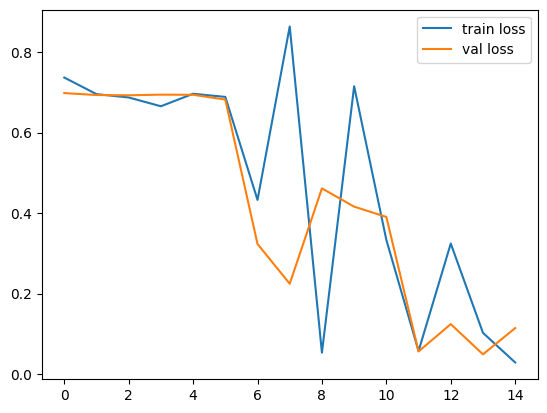

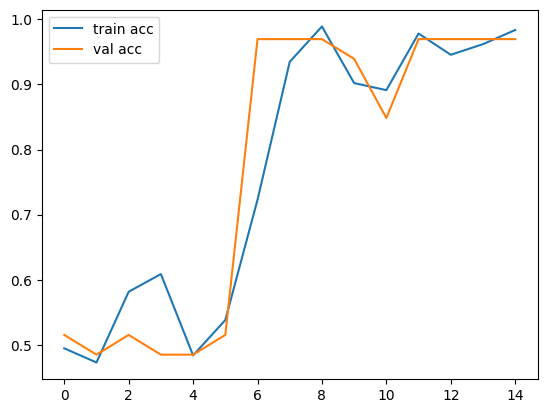

In [ ]:
#plotting the accuracy and loss graph
# loss
print("VGG")
plt.plot(history_vgg.history['loss'], label='train loss')
plt.plot(history_vgg.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history_vgg.history['accuracy'], label='train acc')
plt.plot(history_vgg.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

ResNet


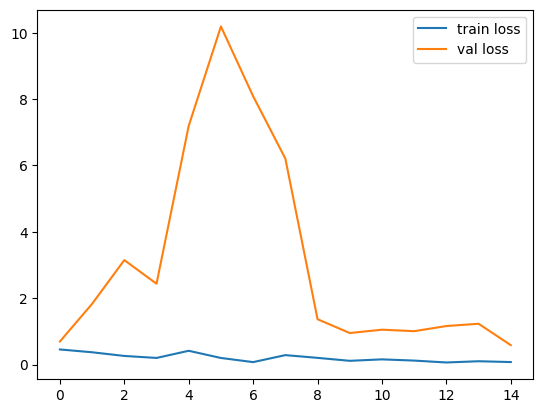

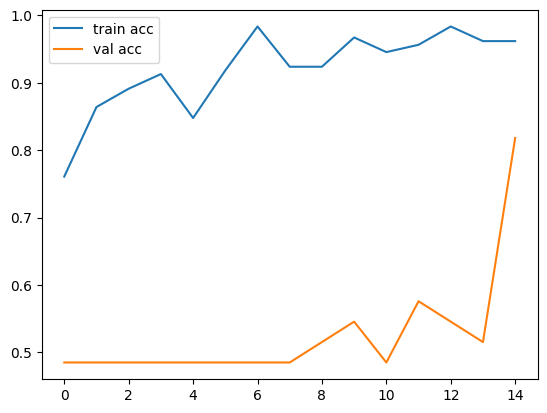

In [ ]:
#plotting the accuracy and loss graph
# loss
print("ResNet")
plt.plot(history_resnet.history['loss'], label='train loss')
plt.plot(history_resnet.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history_resnet.history['accuracy'], label='train acc')
plt.plot(history_resnet.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
#making predictions on the test set
predictions = ensemble_model.predict(test_set,steps=len(test_set), verbose=1)

10/10 [==============================] - 14s 1s/step


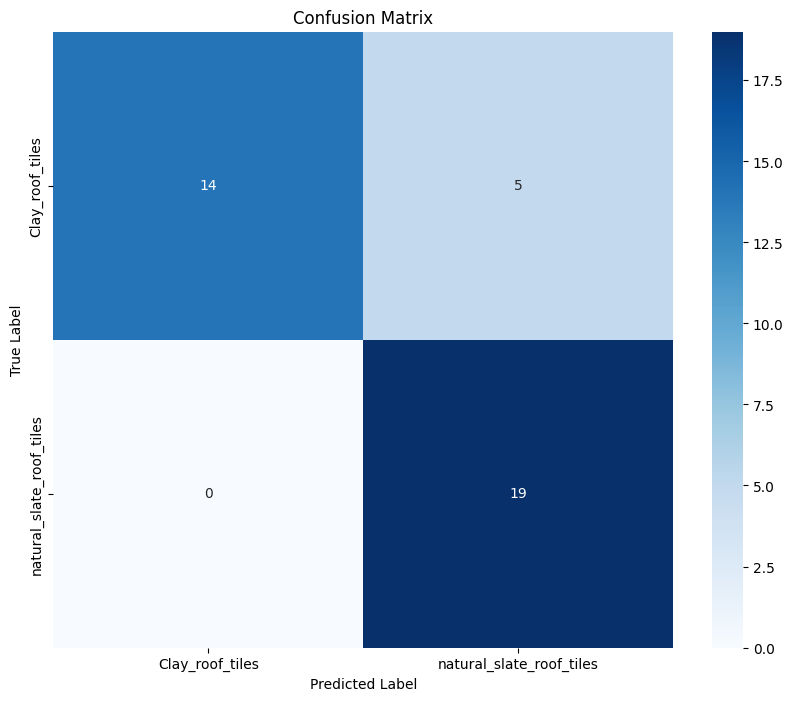

                          precision    recall  f1-score   support

         Clay_roof_tiles       1.00      0.74      0.85        19
natural_slate_roof_tiles       0.79      1.00      0.88        19

                accuracy                           0.87        38
               macro avg       0.90      0.87      0.87        38
            weighted avg       0.90      0.87      0.87        38



In [ ]:
#evaluating the model performance
#getting the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)
#getting the true class indices
true_class_indices = test_set.classes
class_labels = list(test_set.class_indices.keys())
# Generating the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Generating and printing the classification report
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_labels)
print(report)

In [ ]:
ensemble_model.save('TileClassificationEnsemble.h5')

## Roof detection

#### Data loading and preprocessing

In [ ]:
# Define the train, validation, and test dataset paths
train_path = 'G:\\My Drive\\RoofIdentification\\train'
valid_path = 'G:\\My Drive\\RoofIdentification\\val'
test_path1 = 'G:\\My Drive\\RoofIdentification\\roof_images'
test_path2 = 'G:\\My Drive\\RoofIdentification\\test'
# Define the image size
image_size = (224, 224, 3)

# Creating a custom generator
def autoencoder_generator(generator):
    for batch in generator:
        yield (batch, batch)

# Data augmentation for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,   # Randomly shift the image horizontally by 20%
    height_shift_range=0.2,  # Randomly shift the image vertically by 20%
    shear_range=0.2,         # Randomly apply shearing transformations
    zoom_range=0.2,          # Randomly zoom in on images by up to 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in missing pixels with the nearest valid value
)

# No augmentation for validation and test datasets, only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generating the datasets
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=5,
    class_mode=None
)

validation_set = validation_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=33,
    class_mode=None,
    shuffle=False
)

test_set1 = test_datagen.flow_from_directory(
    test_path1,
    target_size=(224, 224),
    batch_size=38,
    class_mode=None,
    shuffle=False
)

test_set2 = test_datagen.flow_from_directory(
    test_path2,
    target_size=(224, 224),
    batch_size=38,
    class_mode=None,
    shuffle=False
)


Found 184 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Found 38 images belonging to 1 classes.
Found 38 images belonging to 1 classes.


#### Approach 1

In [ ]:
# Input shape
input_image = Input(shape=(224, 224, 3))

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_image)


# Freeze all layers in the encoder
for layer in base_model_resnet.layers:
    layer.trainable = False

encoder_output = base_model_resnet.output  # Encoder output


# Decoder
decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

output_image = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder)


# Combine the encoder and decoder
roof_identification_model = Model(inputs=input_image, outputs=output_image)

# Compile the model
roof_identification_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')


roof_identification_model.fit(
    autoencoder_generator(training_set),
    epochs=150,
    steps_per_epoch=len(training_set),
    validation_data=autoencoder_generator(validation_set),
    validation_steps=len(validation_set)
)


Epoch 1/150
37/37 [==============================] - 57s 1s/step - loss: 0.0578 - val_loss: 0.0590
Epoch 2/150
37/37 [==============================] - 43s 1s/step - loss: 0.0541 - val_loss: 0.0576
Epoch 3/150
37/37 [==============================] - 43s 1s/step - loss: 0.0565 - val_loss: 0.0568
Epoch 4/150
37/37 [==============================] - 43s 1s/step - loss: 0.0544 - val_loss: 0.0563
Epoch 5/150
37/37 [==============================] - 45s 1s/step - loss: 0.0551 - val_loss: 0.0563
Epoch 6/150
37/37 [==============================] - 55s 2s/step - loss: 0.0540 - val_loss: 0.0560
Epoch 7/150
37/37 [==============================] - 48s 1s/step - loss: 0.0525 - val_loss: 0.0550
Epoch 8/150
37/37 [==============================] - 47s 1s/step - loss: 0.0552 - val_loss: 0.0570
Epoch 9/150
37/37 [==============================] - 41s 1s/step - loss: 0.0516 - val_loss: 0.0565
Epoch 10/150
37/37 [==============================] - 38s 1s/step - loss: 0.0545 - val_loss: 0.0562
Epoch 11/

In [ ]:
roof_identification_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

ResNet


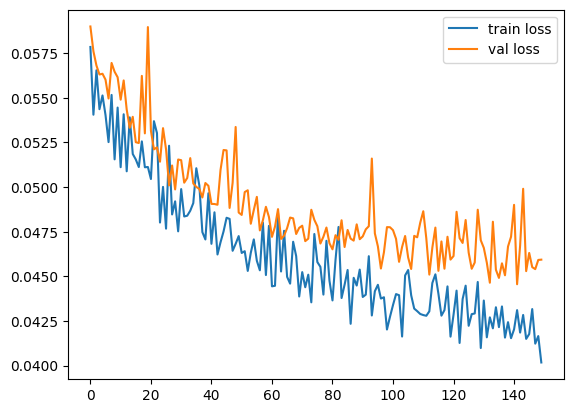

In [ ]:
#plotting the loss graph
# loss
print("ResNet")
history = roof_identification_model.history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [ ]:
roof_identification_model.save('RoofIdentificationAutoEncoderModel1.h5')

In [ ]:

# Load all validation images into a list
validation_images = []
for _ in range(len(validation_set)):
    img = validation_set.next()  # Get the next image
    validation_images.append(img)

# Stack the list into a numpy array
validation_images = np.vstack(validation_images)

# Predict the reconstructed images
reconstructed_validation = roof_identification_model.predict(validation_images)

# Calculate the reconstruction error (Mean Squared Error) for each validation image
validation_errors = np.mean(np.square(validation_images - reconstructed_validation), axis=(1, 2, 3))

# Determine the threshold based on the 95th percentile of reconstruction errors from roof images
threshold = np.percentile(validation_errors, 50)

# Print validation errors and threshold
print("Validation Errors:", validation_errors)
print("Threshold for anomalies:", threshold)

2/2 [==============================] - 2s 125ms/step
Validation Errors: [0.05540247 0.04849835 0.062902   0.0277773  0.05378207 0.04597894
 0.05568028 0.03358794 0.06658095 0.02171059 0.0365965  0.04942211
 0.041876   0.05814466 0.02075729 0.03199676 0.05038719 0.0311584
 0.04948964 0.04114035 0.05025033 0.03273445 0.04006696 0.04090283
 0.03685759 0.04648255 0.04853643 0.07605171 0.03345376 0.05891559
 0.05152764 0.06720222 0.04996223]
Threshold for anomalies: 0.04849834740161896


##### making predictions for positive class

In [ ]:
test_images = next(test_set1)
reconstructed_images = roof_identification_model.predict(test_images)
labels = []
# Compute reconstruction error for each test image
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))
print(reconstruction_errors)
for error in reconstruction_errors:
    if error > 0.05:
        labels.append("Non Roof")
    else:
        labels.append("Roof")
print("Count of Roof Images : " + str(labels.count("Roof")))
print("Count of Non Roof Images : " + str(labels.count("Non Roof")))

2/2 [==============================] - 4s 702ms/step
[0.04597191 0.04379617 0.05159377 0.02491272 0.0429447  0.04849835
 0.02895628 0.02865024 0.04822446 0.03004688 0.06824616 0.04928895
 0.05129934 0.03870305 0.02212068 0.02999773 0.04677243 0.02637881
 0.05980716 0.05528647 0.06687151 0.06838465 0.05086236 0.04612678
 0.03903817 0.04533179 0.04601336 0.04715722 0.04670105 0.02891382
 0.04364609 0.04518458 0.10095416 0.02418517 0.05453226 0.03881267
 0.03063962 0.04009848]
Count of Roof Images : 28
Count of Non Roof Images : 10


##### making predictions for non-roof classess

In [ ]:
test_images = next(test_set2)
reconstructed_images = roof_identification_model.predict(test_images)
labels = []
# Compute reconstruction error for each test image
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))
print(reconstruction_errors)
for error in reconstruction_errors:
    if error > 0.05:
        labels.append("Non Roof")
    else:
        labels.append("Roof")
print("Count of Roof Images : " + str(labels.count("Roof")))
print("Count of Non Roof Images : " + str(labels.count("Non Roof")))

2/2 [==============================] - 5s 1s/step
[0.0933779  0.04754407 0.05642068 0.05403378 0.07116427 0.06021439
 0.12285943 0.14167003 0.12253945 0.04138292 0.05218466 0.07097401
 0.10294525 0.05496274 0.12628569 0.05490091 0.07428201 0.07316703
 0.05378446 0.14331515 0.1606778  0.09371559 0.05032953 0.07226758
 0.05501045 0.06562766 0.05999799 0.0501293  0.11227491 0.05087837
 0.05412361 0.10413972 0.09239665 0.05724936 0.08367883 0.06449937
 0.06156193 0.08533416]
Count of Roof Images : 2
Count of Non Roof Images : 36


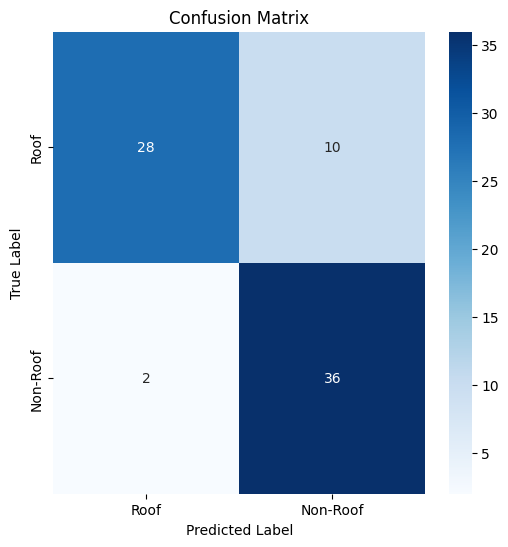

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Confusion matrix data
conf_matrix = np.array([[28, 10], [2, 36]])

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Roof', 'Non-Roof'], yticklabels=['Roof', 'Non-Roof'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Approach 2

In [ ]:
# Input shape
input_image = Input(shape=(224, 224, 3))

# VGG16 Pre-trained Encoder
vgg16 = VGG19(weights='imagenet', include_top=False, input_tensor=input_image)

# Freeze all layers in the encoder
for layer in vgg16.layers:
    layer.trainable = False

encoder_output = vgg16.output  # Encoder output


# Decoder
decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

output_image = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder)


# Combine the encoder and decoder
roof_identification_model = Model(inputs=input_image, outputs=output_image)

# Compile the model
roof_identification_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')


history = roof_identification_model.fit(
    autoencoder_generator(training_set),
    epochs=150,
    steps_per_epoch=len(training_set),
    validation_data=autoencoder_generator(validation_set),
    validation_steps=len(validation_set)
)


Epoch 1/150
37/37 [==============================] - 86s 2s/step - loss: 0.0551 - val_loss: 0.0576
Epoch 2/150
37/37 [==============================] - 71s 2s/step - loss: 0.0552 - val_loss: 0.0526
Epoch 3/150
37/37 [==============================] - 70s 2s/step - loss: 0.0459 - val_loss: 0.0519
Epoch 4/150
37/37 [==============================] - 69s 2s/step - loss: 0.0445 - val_loss: 0.0509
Epoch 5/150
37/37 [==============================] - 83s 2s/step - loss: 0.0477 - val_loss: 0.0488
Epoch 6/150
37/37 [==============================] - 73s 2s/step - loss: 0.0420 - val_loss: 0.0471
Epoch 7/150
37/37 [==============================] - 66s 2s/step - loss: 0.0443 - val_loss: 0.0511
Epoch 8/150
37/37 [==============================] - 72s 2s/step - loss: 0.0426 - val_loss: 0.0471
Epoch 9/150
37/37 [==============================] - 80s 2s/step - loss: 0.0403 - val_loss: 0.0454
Epoch 10/150
37/37 [==============================] - 83s 2s/step - loss: 0.0423 - val_loss: 0.0467
Epoch 11/

In [ ]:
roof_identification_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

VGG19


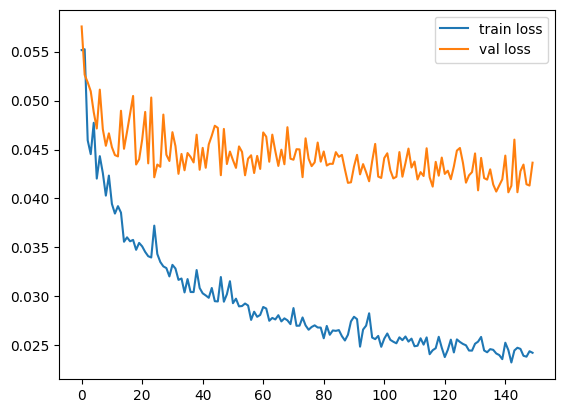

In [ ]:
#plotting the loss graph
# loss
print("VGG19")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [ ]:
# Load all validation images into a list
validation_images = []
for _ in range(len(validation_set)):
    img = validation_set.next()  # Get the next image
    validation_images.append(img)

# Stack the list into a numpy array
validation_images = np.vstack(validation_images)

# Predict the reconstructed images
reconstructed_validation = roof_identification_model.predict(validation_images)

# Calculate the reconstruction error (Mean Squared Error) for each validation image
validation_errors = np.mean(np.square(validation_images - reconstructed_validation), axis=(1, 2, 3))

# Determine the threshold based on the 95th percentile of reconstruction errors from roof images
threshold = np.percentile(validation_errors, 50)

# Print validation errors and threshold
print("Validation Errors:", validation_errors)
print("Threshold for anomalies:", threshold)

2/2 [==============================] - 7s 252ms/step
Validation Errors: [0.04663198 0.05282621 0.04762721 0.03862125 0.02865101 0.03422891
 0.08021659 0.03094353 0.09748745 0.03542194 0.02398352 0.07467315
 0.02848187 0.03925939 0.03297187 0.05509105 0.02960109 0.03032013
 0.0528939  0.04227565 0.0545083  0.03560279 0.03491262 0.01652407
 0.03949975 0.04318412 0.03735599 0.04422959 0.02052657 0.05791305
 0.05099773 0.06288311 0.04026596]
Threshold for anomalies: 0.03949975222349167


In [ ]:
roof_identification_model.save('RoofIdentificationAutoEncoderModel2.h5')

In [ ]:
test_images = next(test_set1)
reconstructed_images = roof_identification_model.predict(test_images)
labels = []
# Compute reconstruction error for each test image
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))
print(reconstruction_errors)
for error in reconstruction_errors:
    if error > 0.04:
        labels.append("Non Roof")
    else:
        labels.append("Roof")
print("Count of Roof Images : " + str(labels.count("Roof")))
print("Count of Non Roof Images : " + str(labels.count("Non Roof")))

2/2 [==============================] - 6s 943ms/step
[0.03867011 0.04793902 0.03634475 0.02440158 0.04822531 0.05282621
 0.02355392 0.01834236 0.03191237 0.02742497 0.04541415 0.04787046
 0.04867643 0.02239482 0.01574886 0.03069784 0.0410753  0.04559749
 0.04064788 0.02944628 0.01612482 0.05663247 0.03361069 0.03286124
 0.0338993  0.02644305 0.02278975 0.03766643 0.03478192 0.03840455
 0.0467112  0.03559542 0.0710067  0.01980258 0.04849297 0.03170223
 0.01746169 0.06468149]
Count of Roof Images : 24
Count of Non Roof Images : 14


In [ ]:
test_images = next(test_set2)
reconstructed_images = roof_identification_model.predict(test_images)
labels = []
# Compute reconstruction error for each test image
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))
print(reconstruction_errors)
for error in reconstruction_errors:
    if error > 0.04:
        labels.append("Non Roof")
    else:
        labels.append("Roof")
print("Count of Roof Images : " + str(labels.count("Roof")))
print("Count of Non Roof Images : " + str(labels.count("Non Roof")))

2/2 [==============================] - 6s 943ms/step
[0.07752044 0.04249161 0.05764344 0.07321776 0.05456119 0.04811002
 0.0847913  0.07724649 0.11375273 0.04359388 0.04506826 0.05233026
 0.10458577 0.06069666 0.0798186  0.04891973 0.04410441 0.07570401
 0.06283174 0.14298554 0.13093117 0.05948979 0.06328778 0.07539886
 0.07259142 0.04106993 0.04424622 0.04793462 0.11093569 0.03815603
 0.05208786 0.10113478 0.06877941 0.0434649  0.07765979 0.0446174
 0.05977241 0.04740032]
Count of Roof Images : 1
Count of Non Roof Images : 37


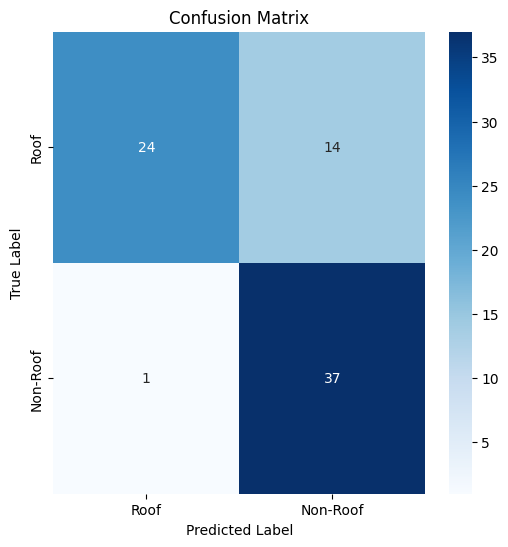

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Confusion matrix data
conf_matrix = np.array([[24, 14], [1, 37]])

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Roof', 'Non-Roof'], yticklabels=['Roof', 'Non-Roof'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Roof Segmentation

In [ ]:

class DataGenerator(Sequence):
    def __init__(self, directory, batch_size=16, target_size=(256, 256), category_id=1):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.category_id = category_id
        self.images, self.annotations = self.load_annotations()
        self.on_epoch_end()

    def load_annotations(self):
        # Load the annotation.coco file
        annotation_path = os.path.join(self.directory, '_annotations.coco.json')
        with open(annotation_path, 'r') as f:
            coco_segmentation_data = json.load(f)

        images = coco_segmentation_data['images']
        annotations = coco_segmentation_data['annotations']
        return images, annotations

    def create_segmentation_mask(self, image_size, annotations, category_id):
        mask = np.zeros(image_size, dtype=np.uint8)
        for ann in annotations:
            if ann['category_id'] == category_id:
                segmentation = ann['segmentation'][0]
                polygon = np.array(segmentation).reshape((-1, 2))
                polygon = [tuple(point) for point in polygon]
                img = Image.new('L', (image_size[1], image_size[0]), 0)
                ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
                mask += np.array(img)
        return mask

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []

        for image_info in batch_images:
            image_id = image_info['id']
            file_name = image_info['file_name']
            height, width = image_info['height'], image_info['width']

            # Load image
            image_path = os.path.join(self.directory, file_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.target_size)
            image = image / 255.0  # Normalize the image

            # Find annotations for the image
            annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]

            # Create segmentation mask
            mask = self.create_segmentation_mask((height, width), annotations, category_id=self.category_id)
            mask = cv2.resize(mask, self.target_size)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        np.random.shuffle(self.images)


In [ ]:
def evaluate_model_on_test_data(model, test_gen):
    iou_scores = []
    dice_scores = []
    pixel_acc_scores = []

    # Loop over the test data batches
    for images, masks in test_gen:
        # Predict the masks using the model
        y_predictions = model.predict(images)

        # Threshold the predicted masks (binary segmentation)
        y_predictions = (y_predictions > 0.5).astype(np.float32)

        # Loop over the batch
        for i in range(len(masks)):
            y_true = masks[i]
            y_predictions_single = y_predictions[i]

            # Compute IoU
            intersection = np.sum(np.abs(y_true * y_predictions_single))
            union = np.sum(y_true) + np.sum(y_predictions_single) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_scores.append(iou)

            # Compute Dice coefficient
            dice = (2. * intersection + 1e-6) / (np.sum(y_true) + np.sum(y_predictions_single) + 1e-6)
            dice_scores.append(dice)

            # Compute Pixel Accuracy
            correct_pixels = np.sum(y_true == y_predictions_single)
            total_pixels = y_true.size
            pixel_acc = correct_pixels / total_pixels
            pixel_acc_scores.append(pixel_acc)

    # Calculate the mean of the metrics
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_pixel_acc = np.mean(pixel_acc_scores)

    return mean_iou, mean_dice, mean_pixel_acc


#### segmentation model 1

In [ ]:
def segmentation_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)


    # Decoder
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)


    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)  # Sigmoid for binary segmentation

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
# Paths to the directories
train_dir = 'G:/My Drive/Roof Segmentation/train/'
val_dir = 'G:/My Drive/Roof Segmentation/valid/'
test_dir = 'G:/My Drive/Roof Segmentation/test/'

# Create the data generators
train_gen = DataGenerator(directory=train_dir, batch_size=16, target_size=(256, 256), category_id=1)
val_gen = DataGenerator(directory=val_dir, batch_size=16, target_size=(256, 256), category_id=1)
test_gen = DataGenerator(directory=test_dir, batch_size=16, target_size=(256, 256), category_id=1)

# Build the UNet model
model = segmentation_model(input_size=(256, 256, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen)

# Save the model
model.save('roof_segmentation_model2.h5')


Epoch 1/10
22/22 [==============================] - 774s 35s/step - loss: 0.3370 - accuracy: 0.9105 - val_loss: 0.2913 - val_accuracy: 0.9033
Epoch 2/10
22/22 [==============================] - 646s 29s/step - loss: 0.2707 - accuracy: 0.9109 - val_loss: 0.2626 - val_accuracy: 0.9016
Epoch 3/10
22/22 [==============================] - 641s 29s/step - loss: 0.2318 - accuracy: 0.9117 - val_loss: 0.2188 - val_accuracy: 0.8986
Epoch 4/10
22/22 [==============================] - 636s 29s/step - loss: 0.2191 - accuracy: 0.9112 - val_loss: 0.2106 - val_accuracy: 0.8991
Epoch 5/10
22/22 [==============================] - 622s 28s/step - loss: 0.1940 - accuracy: 0.9114 - val_loss: 0.1724 - val_accuracy: 0.9043
Epoch 6/10
22/22 [==============================] - 655s 30s/step - loss: 0.1825 - accuracy: 0.9288 - val_loss: 0.1835 - val_accuracy: 0.9160
Epoch 7/10
22/22 [==============================] - 630s 29s/step - loss: 0.1602 - accuracy: 0.9392 - val_loss: 0.1560 - val_accuracy: 0.9481
Epoch 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

UNET


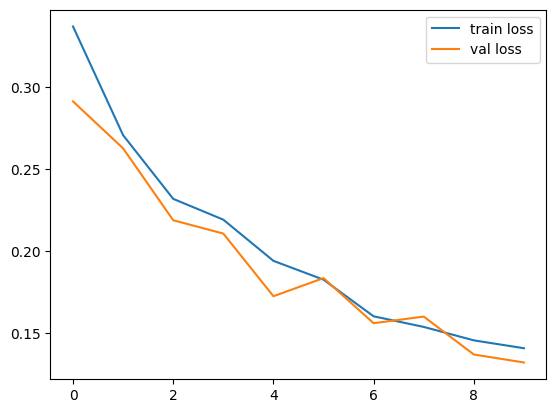

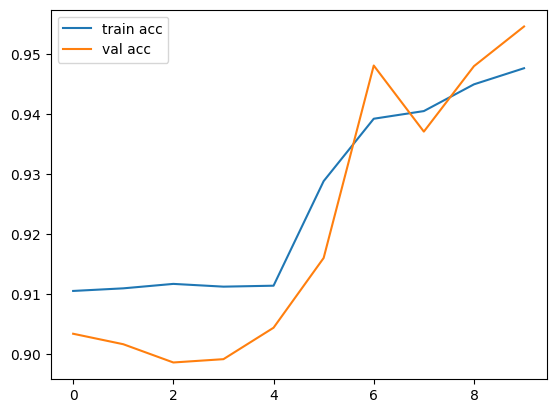

In [ ]:
#plotting the accuracy and loss graph
# loss
print("UNET")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 7s 7s/step - loss: 0.1449 - accuracy: 0.9477
Test Loss: 0.14486506581306458
Test Accuracy: 0.9477024078369141


In [ ]:
# Evaluate on the test set
mean_iou, mean_dice, mean_pixel_acc = evaluate_model_on_test_data(model, test_gen)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice Coefficient: {mean_dice}")
print(f"Mean Pixel Accuracy: {mean_pixel_acc}")

1/1 [==============================] - 5s 5s/step
Mean IoU: 0.445825986868473
Mean Dice Coefficient: 0.578232187412507
Mean Pixel Accuracy: 0.9504375457763672


#### Roof segmentation model 2

In [ ]:
def segmentation_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)


    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Sigmoid for binary segmentation

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
# Paths to the directories
train_dir = 'G:/My Drive/Roof Segmentation/train/'
val_dir = 'G:/My Drive/Roof Segmentation/valid/'
test_dir = 'G:/My Drive/Roof Segmentation/test/'

# Create the data generators
train_gen = DataGenerator(directory=train_dir, batch_size=16, target_size=(256, 256), category_id=1)
val_gen = DataGenerator(directory=val_dir, batch_size=16, target_size=(256, 256), category_id=1)
test_gen = DataGenerator(directory=test_dir, batch_size=16, target_size=(256, 256), category_id=1)

# Build the UNet model
model = segmentation_model(input_size=(256, 256, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen)

# Save the model
model.save('roof_segmentation_model5.h5')


Epoch 1/10
22/22 [==============================] - 309s 14s/step - loss: 0.3523 - accuracy: 0.8737 - val_loss: 0.2954 - val_accuracy: 0.9045
Epoch 2/10
22/22 [==============================] - 292s 13s/step - loss: 0.2664 - accuracy: 0.9115 - val_loss: 0.3065 - val_accuracy: 0.8999
Epoch 3/10
22/22 [==============================] - 283s 13s/step - loss: 0.2483 - accuracy: 0.9110 - val_loss: 0.2877 - val_accuracy: 0.8958
Epoch 4/10
22/22 [==============================] - 282s 13s/step - loss: 0.2532 - accuracy: 0.9107 - val_loss: 0.2437 - val_accuracy: 0.9016
Epoch 5/10
22/22 [==============================] - 296s 13s/step - loss: 0.2369 - accuracy: 0.9118 - val_loss: 0.2377 - val_accuracy: 0.8988
Epoch 6/10
22/22 [==============================] - 285s 13s/step - loss: 0.2130 - accuracy: 0.9111 - val_loss: 0.2192 - val_accuracy: 0.8989
Epoch 7/10
22/22 [==============================] - 283s 13s/step - loss: 0.1653 - accuracy: 0.9200 - val_loss: 0.1491 - val_accuracy: 0.9292
Epoch 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

UNET


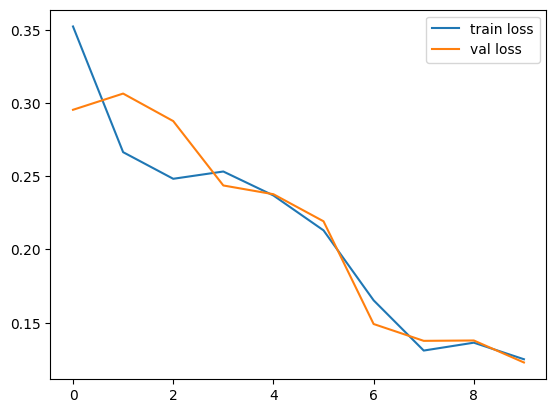

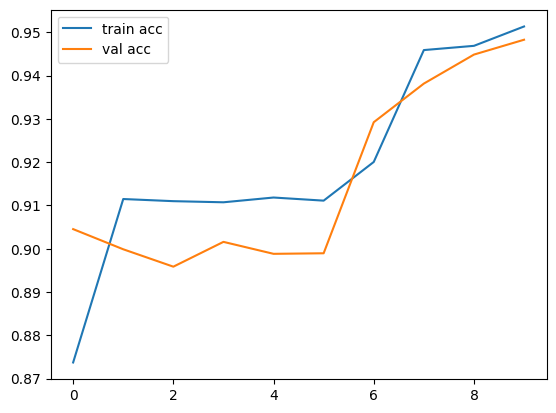

In [ ]:
#plotting the accuracy and loss graph
# loss
print("UNET")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 3s 3s/step - loss: 0.1221 - accuracy: 0.9532
Test Loss: 0.122127965092659
Test Accuracy: 0.9531946182250977


In [ ]:
# Evaluate on the test set
mean_iou, mean_dice, mean_pixel_acc = evaluate_model_on_test_data(model, test_gen)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice Coefficient: {mean_dice}")
print(f"Mean Pixel Accuracy: {mean_pixel_acc}")

1/1 [==============================] - 3s 3s/step
Mean IoU: 0.40670462269164526
Mean Dice Coefficient: 0.5273396199465715
Mean Pixel Accuracy: 0.9435520172119141


# **Frontend application**

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox, Canvas, Scrollbar, Frame
from PIL import Image, ImageTk
import requests

def upload_image():
    """Function to upload the image """
    image_input = image_path_entry.get()

    image_input = image_input.replace("\\", "/")

    if not image_input:
        messagebox.showerror("Error", "Please provide a valid file path.")
        return

    payload = {"image": image_input}

    try:
        response = requests.post('http://127.0.0.1:8000/automation/roofDamageDetection', json=payload)
        data = response.json()

        if response.status_code == 200:
            # Check for "roof" in response
            if 'roof' in data:
                roof_status = data['roof']
                result_label.config(text=f"Results:\nRoof: {roof_status}", fg="black")
                if 'tile_type' in data:
                    tile_type = data['tile_type']
                if 'damage_percentage' in data:
                    damage_percentage = data['damage_percentage']
                    result_label.config(text=f"Results:\nRoof: {roof_status}\nTile Type: {tile_type}\nDamage Percentage: {damage_percentage}", fg="black")
                # Show original image if provided
                display_uploaded_image(image_input, original_image_label)
                original_frame.pack(side="left", expand=True)

                # Handle additional responses
                if 'segmented_image' in data:
                    display_uploaded_image(data['segmented_image'], segmented_image_label)
                    segmented_frame.pack(side="left", expand=True)

                if 'damage_detected_regions' in data:
                    display_uploaded_image(data['damage_detected_regions'], damage_boxes_image_label)
                    damage_boxes_frame.pack(side="left", expand=True)

            else:
                # No valid response keys
                result_label.config(text="Incomplete analysis results.", fg="red")
                clear_images()

        else:
            # Backend error response
            messagebox.showerror("Error", data.get('detail', 'Unknown error occurred.'))
            clear_images()

    except Exception as e:
        # Connection error
        messagebox.showerror("Error", f"Could not connect to backend: {e}")
        clear_images()

# Function to display an image
def display_uploaded_image(image_source, image_label):
    try:
        img = Image.open(image_source)
        img.thumbnail((350, 350))  # Resize image if too large
        img_tk = ImageTk.PhotoImage(img)
        image_label.config(image=img_tk)
        image_label.image = img_tk
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load image: {e}")

# Function to clear images and reset results
def clear_images():
    result_label.config(text="Results will appear here after analysis.", fg="#333")
    for label in [original_image_label, segmented_image_label, damage_boxes_image_label]:
        label.config(image="")
        label.image = None
    image_path_entry.delete(0, tk.END)

    # Hide image labels
    original_frame.pack_forget()
    segmented_frame.pack_forget()
    damage_boxes_frame.pack_forget()

# Tkinter UI setup
root = tk.Tk()
root.title("Roof Damage Detection")
root.geometry("1200x900")
root.resizable(True, True)
root.configure(bg="#f0f8ff")

# Main Heading
heading_label = tk.Label(
    root,
    text="Roof Damage Detection System",
    font=("Helvetica", 28, "bold"),
    bg="#4682b4",
    fg="white",
    pady=15
)
heading_label.pack(fill="x")

# Instructions
instruction_label = tk.Label(
    root,
    text="Upload an image to detect roof damage and analyze tile type.",
    font=("Helvetica", 16),
    bg="#f0f8ff",
    fg="#333",
    pady=10
)
instruction_label.pack()

# Input Section
input_frame = tk.Frame(root, bg="#f0f8ff")
input_frame.pack(pady=20)

# Image Path Entry
image_path_entry = tk.Entry(input_frame, width=50, font=("Helvetica", 14))
image_path_entry.pack(side="left", padx=10)

# Browse Button
browse_button = tk.Button(
    input_frame,
    text="Browse",
    font=("Helvetica", 12),
    bg="#4682b4",
    fg="white",
    command=lambda: image_path_entry.insert(0, filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")]
    )),
)
browse_button.pack(side="left", padx=10)

# Analyze Button
upload_button = tk.Button(
    input_frame,
    text="Analyze",
    command=upload_image,
    font=("Helvetica", 12),
    bg="#4caf50",
    fg="white",
    activebackground="#66bb6a",
    activeforeground="white",
    width=10
)
upload_button.pack(side="left", padx=10)

# Clear Button
clear_button = tk.Button(
    root,
    text="Clear",
    font=("Helvetica", 12),
    bg="#e57373",
    fg="white",
    command=clear_images,
    activebackground="#ef9a9a",
    activeforeground="white",
    width=10
)
clear_button.place(x=1100, y=10)  # Adjust placement as needed

# Results Section
result_label = tk.Label(
    root,
    text="Results will appear here after analysis.",
    font=("Helvetica", 14),
    bg="#f0f8ff",
    fg="#333",
    wraplength=800,
    justify="center"
)
result_label.pack(pady=10)

# Scrollable Image Display Section
visualization_frame = tk.Frame(root, bg="#f0f8ff", pady=10)
visualization_frame.pack(fill="both", expand=True)

# Scrollbar setup
scroll_canvas = Canvas(visualization_frame, bg="#f0f8ff")
scroll_canvas.pack(side="left", fill="both", expand=True)

scrollbar = Scrollbar(visualization_frame, orient="vertical", command=scroll_canvas.yview)
scrollbar.pack(side="right", fill="y")

scrollable_frame = Frame(scroll_canvas, bg="#f0f8ff")
scroll_canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")

scroll_canvas.configure(yscrollcommand=scrollbar.set)

# Original Image Display
original_frame = tk.Frame(scrollable_frame, bg="#f0f8ff", padx=20)
tk.Label(original_frame, text="Original Image", font=("Helvetica", 14), bg="#f0f8ff", fg="#333").pack()
original_image_label = tk.Label(original_frame)
original_image_label.pack(pady=10)
original_frame.pack_forget()  # Hide initially

# Segmented Image Display
segmented_frame = tk.Frame(scrollable_frame, bg="#f0f8ff", padx=20)
tk.Label(segmented_frame, text="Segmented Image", font=("Helvetica", 14), bg="#f0f8ff", fg="#333").pack()
segmented_image_label = tk.Label(segmented_frame)
segmented_image_label.pack(pady=10)
segmented_frame.pack_forget()  # Hide initially

# Damage Bounding Boxes Image Display
damage_boxes_frame = tk.Frame(scrollable_frame, bg="#f0f8ff", padx=20)
tk.Label(damage_boxes_frame, text="Damage Detected Regions", font=("Helvetica", 14), bg="#f0f8ff", fg="#333").pack()
damage_boxes_image_label = tk.Label(damage_boxes_frame)
damage_boxes_image_label.pack(pady=10)
damage_boxes_frame.pack_forget()  # Hide initially

# Footer
footer_label = tk.Label(
    root,
    text="© 2024 Roof Analysis Co. All rights reserved.",
    font=("Helvetica", 10),
    bg="#f0f8ff",
    fg="#666"
)
footer_label.pack(side="bottom", pady=10)

# Scroll region update
scrollable_frame.bind(
    "<Configure>",
    lambda e: scroll_canvas.configure(scrollregion=scroll_canvas.bbox("all"))
)

# Run the app
root.mainloop()